# Cliopatria viewer

1. To get started, download a copy of the Cliopatria dataset from here: `[INSERT LINK]`
2. `(OPTIONAL)` You can also download the GADM modern borders dataset from here `[INSERT LINK]`
3. Move the downloaded shape dataset(s) to an appropriate location on your machine and pass in the paths in the code cell below and run
4. Run the subsequent cells of the notebook


In [1]:
# cliopatria_path = "path/to/cliopatria_dir/"
# gadm_path = "path/to/gadm_410.gpkg"
cliopatria_geojson_path = "../data/cliopatria_05192024/cliopatria.geojson"
cliopatria_json_path = "../data/cliopatria_05192024/name_years.geojson"
gadm_path = "../data/gadm_410.gpkg"

In [2]:
import geopandas as gpd

# Load the geojson file
gdf = gpd.read_file(cliopatria_geojson_path)

# Display the loaded data
print(gdf.head())

                             Name  Year      Area_km2    Type  \
0            Sumerian City-States -3400  22083.609657  POLITY   
1            Sumerian City-States -3200  35508.841506  POLITY   
2                            Elam -3200   4919.440675  POLITY   
3            Sumerian City-States -3000  45135.556672  POLITY   
4  Early Dynastic Period of Egypt -3000  92480.979261  POLITY   

                       Wikipedia     Color      SeshatID Member_of Components  \
0               History of Sumer  0x800000                                      
1               History of Sumer  0x800000                                      
2                           Elam  0xd9b800                                      
3               History of Sumer  0x800000                                      
4  Early Dynastic Period (Egypt)  0x808000  eg_dynasty_1                        

                                            geometry  
0  POLYGON ((46.58681 31.27192, 46.43482 31.27192...  
1  POLYGON (

In [3]:
# Filter the polygons based on the year column
filtered_gdf = gdf[(gdf['Year'] >= 0) & (gdf['Year'] <= 100)]

In [4]:
import matplotlib.pyplot as plt
import contextily as ctx

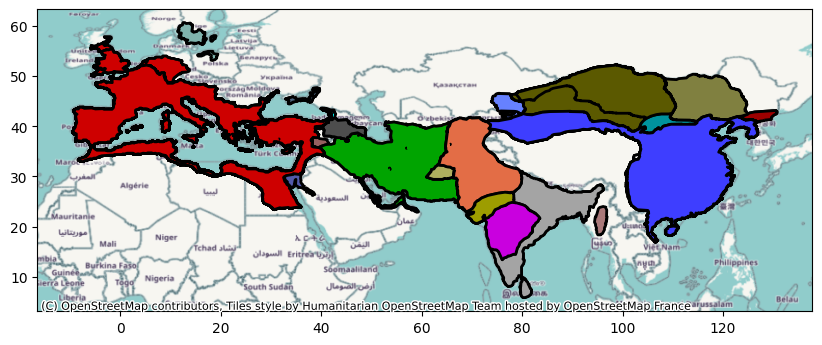

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

# Remove '0x' and add '#' to the start of the color strings
colors = '#' + filtered_gdf['Color'].str.replace('0x', '')

# Plot the polygons with colors based on the 'Color' field
filtered_gdf.plot(ax=ax, linewidth=2, edgecolor='black', facecolor=colors)

# Add a basemap
ctx.add_basemap(ax, crs=filtered_gdf.crs.to_string())

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Remove '0x' and add '#' to the start of the color strings
colors = '#' + filtered_gdf['Color'].str.replace('0x', '')

# Plot the polygons with colors based on the 'Color' field
filtered_gdf.plot(ax=ax, linewidth=2, edgecolor='black', facecolor=colors)

# Add a basemap
ctx.add_basemap(ax, crs=filtered_gdf.crs.to_string())

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons with colors based on the 'Color' field
filtered_gdf.plot(ax=ax, linewidth=2, edgecolor='black', facecolor=filtered_gdf['Color'])

# Add a basemap
ctx.add_basemap(ax, crs=filtered_gdf.crs.to_string())

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons with colors based on the 'Color' field
filtered_gdf.plot(ax=ax, linewidth=2, edgecolor='black', color=filtered_gdf['Color'])

# Add a basemap
ctx.add_basemap(ax, crs=filtered_gdf.crs.to_string())

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons with colors based on the 'Color' field
filtered_gdf.plot(ax=ax, linewidth=2, edgecolor='black', color=filtered_gdf['Color'])

# Add a basemap
ctx.add_basemap(ax, crs=filtered_gdf.crs.to_string())

plt.show()